# Questions

1. Are the costs in the 'api_adwords_costs' table fully covered in the 'session_sources' table? Any campaigns where you see issues?

2. Are the conversions in the 'conversions' table stable over time? Any pattern?

3. Double check conversions ('conversions' table) with backend ('conversions_backend' table), any issues?

4. Are attribution results consistent? Do you find any conversions where the 'ihc' values don't make sense?

5. (Bonus) Do we have an issue with channeling? Are the number of sessions per channel stable over time?

6. (Bonus) Any other issues?


## Imports

In [338]:
import sqlite3
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


## Initialisations

In [339]:
## Initialise paths
db_path = os.path.join('../', 'challenge.db')


## Connect to the db

In [340]:
conn  = sqlite3.connect(db_path)

## Fetch data from db

In [341]:
# Query the db
tables_list = ['conversions', 'session_sources', 'conversions_backend', 'api_adwords_costs', 'attribution_customer_journey']
dataframes = {}
for table in tables_list:
    query = f"SELECT * FROM {table}"
    df_name = f"{table}_df"
    dataframes[df_name] = pd.read_sql_query(query, conn)

# Close db connnection    
conn.close()

In [342]:
# Create dataframes for each table
conversions_df = dataframes['conversions_df']
session_sources_df = dataframes['session_sources_df']
conversions_backend_df = dataframes['conversions_backend_df']
api_adwords_costs_df = dataframes['api_adwords_costs_df']
attribution_customer_journey_df = dataframes['attribution_customer_journey_df']

### Question 1: 

#### Are the costs in the ‘api_adwords_costs’ table fully covered in the ‘session_sources’ table? Any campaigns where you see issues?

In [343]:
# Check the api_adwords_costs_df records
print(api_adwords_costs_df.shape)
api_adwords_costs_df.head(3)

(2987, 4)


,event_date,campaign_id,cost,clicks
0,2021-07-04,campaign_id_149,3554.289,5256
1,2021-07-03,campaign_id_149,3021.879,6180
2,2021-07-01,campaign_id_149,2986.968,7467


In [344]:
# Check the session_sources_df records
print(session_sources_df.shape)
session_sources_df.head(3)

(1616702, 9)


,session_id,user_id,event_date,event_time,channel_name,campaign_name,campaign_id,market,cpc
0,session_id_660241,user_id_814496,2021-07-03,05:30:20,Affiliate,campaign_name_716,notset,NL,0.018
1,session_id_9812,user_id_752875,2021-07-19,16:00:40,Affiliate,campaign_name_108,notset,FR,0.000
2,session_id_780253,user_id_156905,2021-07-31,07:50:23,Affiliate,campaign_name_741,notset,DE,0.022


In [345]:
# Group the api_adwords_costs_df data by event date and campaign id and take the sum of cost

api_adwords_costs_agg = api_adwords_costs_df.groupby(['event_date', 'campaign_id']).agg(
    total_cost=('cost', 'sum')).reset_index()
print(api_adwords_costs_agg.shape)
api_adwords_costs_agg.head(3)

(2987, 3)


,event_date,campaign_id,total_cost
0,2021-07-01,campaign_id_10,292.73
1,2021-07-01,campaign_id_100,11.57
2,2021-07-01,campaign_id_101,8.90


In [346]:
# Group the session_sources_df data by event date and campaign id and take the sum of cpc

session_sources_agg = session_sources_df.groupby(['event_date', 'campaign_id']).agg(
    total_cpc=('cpc', 'sum')).reset_index()
print(session_sources_agg.shape)
session_sources_agg.head(3)

(3537, 3)


,event_date,campaign_id,total_cpc
0,2021-07-01,campaign_id_1,0.000
1,2021-07-01,campaign_id_10,292.807
2,2021-07-01,campaign_id_100,11.572


In [347]:
# Merge the two dataframes so that we can compare the costs
cost_coverage = pd.merge(api_adwords_costs_agg, session_sources_agg, on=['event_date', 'campaign_id'], how='left', suffixes=('_adwords', '_session'))
print(cost_coverage.shape)
cost_coverage.head()

(2987, 4)


,event_date,campaign_id,total_cost,total_cpc
0,2021-07-01,campaign_id_10,292.73,292.807
1,2021-07-01,campaign_id_100,11.57,11.572
2,2021-07-01,campaign_id_101,8.90,8.899
3,2021-07-01,campaign_id_103,6.01,5.460
4,2021-07-01,campaign_id_106,62.66,62.672


In [348]:
# Check if there are any null values
cost_coverage.isnull().sum()

event_date      0
campaign_id     0
total_cost      0
total_cpc      79
dtype: int64

In [349]:
# Where are the null values?
cost_coverage[cost_coverage['total_cpc'].isna()]

,event_date,campaign_id,total_cost,total_cpc
12,2021-07-01,campaign_id_121,2.250,NaN
81,2021-07-01,campaign_id_7,1.844,NaN
102,2021-07-01,campaign_id_97,7.820,NaN
116,2021-07-02,campaign_id_121,8.390,NaN
138,2021-07-02,campaign_id_156,7.031,NaN
...,...,...,...,...
2808,2021-07-29,campaign_id_97,4.940,NaN
2819,2021-07-30,campaign_id_121,9.710,NaN
2897,2021-07-30,campaign_id_97,15.750,NaN
2908,2021-07-31,campaign_id_121,8.750,NaN


In [350]:
# Fill null values with 0
cost_coverage['total_cpc'].fillna(0, inplace=True)

In [351]:
# Check for any cost difference
cost_coverage['cost_difference'] = abs(cost_coverage['total_cost'] - cost_coverage['total_cpc'])
discrepancies = cost_coverage[(cost_coverage['cost_difference']) != 0]
discrepancies.head()

,event_date,campaign_id,total_cost,total_cpc,cost_difference
0,2021-07-01,campaign_id_10,292.73,292.807,0.077
1,2021-07-01,campaign_id_100,11.57,11.572,0.002
2,2021-07-01,campaign_id_101,8.90,8.899,0.001
3,2021-07-01,campaign_id_103,6.01,5.460,0.550
4,2021-07-01,campaign_id_106,62.66,62.672,0.012


In [352]:
if not discrepancies.empty:
    print(f"Number of campaigns with cost discrepancies are {discrepancies.shape[0]}")
else:
    print("All costs are fully covered in the session sources.")

Number of campaigns with cost discrepancies are 2532


In [353]:
# max cost difference
discrepancies.sort_values(by=['cost_difference'], ascending=False).head(10)

,event_date,campaign_id,total_cost,total_cpc,cost_difference
89,2021-07-01,campaign_id_79,584.017,0.0,584.017
1299,2021-07-13,campaign_id_79,500.650,0.0,500.650
1098,2021-07-11,campaign_id_79,489.728,0.0,489.728
1199,2021-07-12,campaign_id_79,487.640,0.0,487.640
397,2021-07-04,campaign_id_79,474.387,0.0,474.387
1400,2021-07-14,campaign_id_79,463.274,0.0,463.274
799,2021-07-08,campaign_id_79,461.032,0.0,461.032
193,2021-07-02,campaign_id_79,449.084,0.0,449.084
2432,2021-07-25,campaign_id_79,425.826,0.0,425.826
2524,2021-07-26,campaign_id_79,419.281,0.0,419.281


In [354]:
# Find out how many unique campaign are there with a mismatch between cost and cpc
len(discrepancies['campaign_id'].unique())

108

We can see that there are cost discrepancies between api adwords table and session sources table however negligible. If these negligible differences are permissible or normal then a threshold can be established to consider only the significant discrepancies in cost.

### Question 2

#### Are the conversions in the 'conversions' table stable over time? Any pattern?

In [355]:
# Check the values of conversions dataframe
conversions_df.head(3)

,conv_id,user_id,conv_date,market,revenue
0,conv_id_16788,user_id_569581,2021-07-15,NL,219.73
1,conv_id_9916,user_id_62541,2021-07-15,DE,104.21
2,conv_id_8443,user_id_494266,2021-07-15,NL,55.69


In [356]:
conversions_df_task2 = conversions_df.copy() # Make a copy of the df so that operations can be done on it without affecting the original df

# Convert conv_date to datetime
conversions_df_task2['conv_date'] = pd.to_datetime(conversions_df_task2['conv_date'])

# Update month_year to dd-mm-yyyy format
conversions_df_task2['time'] = conversions_df_task2['conv_date'].dt.strftime('%d-%m-%Y')

In [357]:
# Group by the time
monthly_conversions = conversions_df_task2.groupby('time').agg({'conv_id': 'count', 'revenue': 'sum'}).reset_index()
monthly_conversions.head(3)

,time,conv_id,revenue
0,15-07-2021,968,48140.04
1,16-07-2021,809,38388.89
2,17-07-2021,691,34721.01


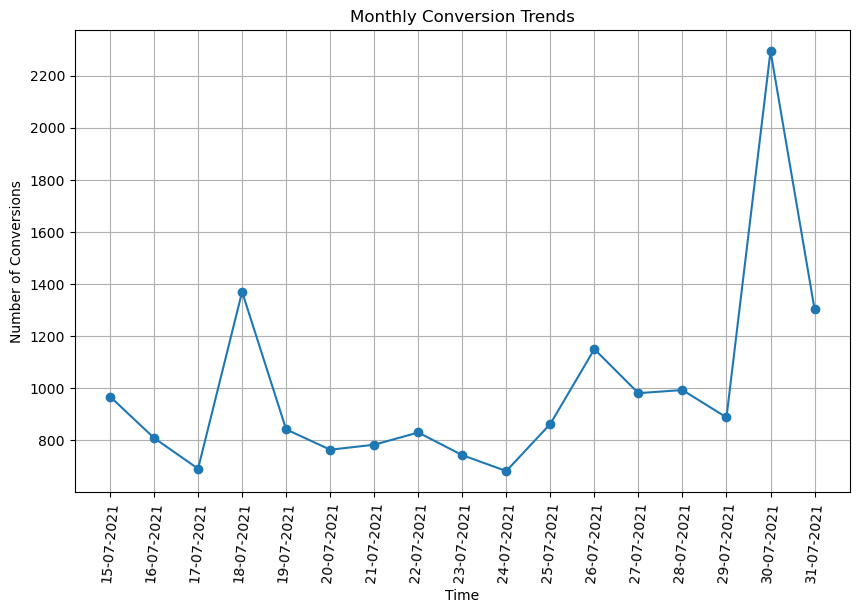

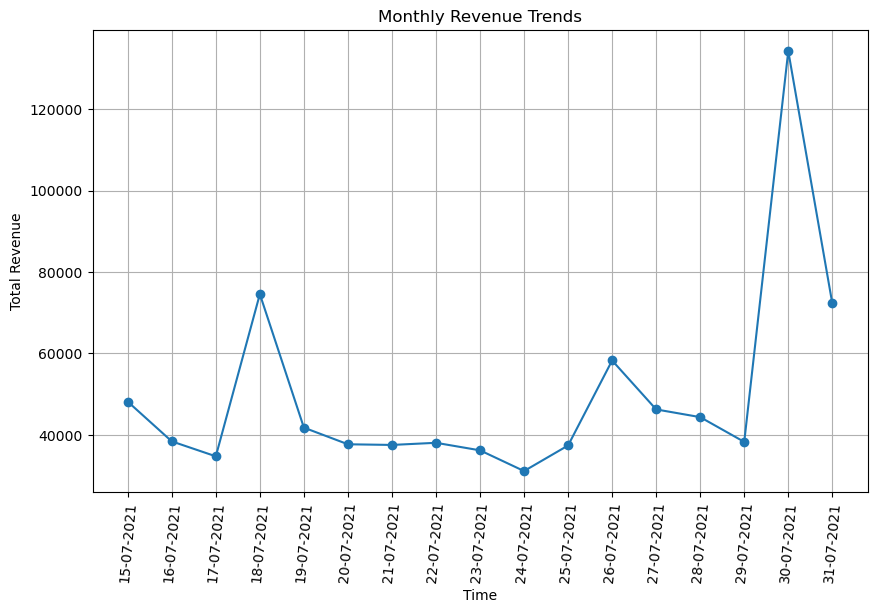

In [358]:
# Count conversions and sum revenue per month
monthly_conversions = conversions_df_task2.groupby('time').agg({'conv_id': 'count', 'revenue': 'sum'}).reset_index()

# Plotting number of conversions over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_conversions['time'], monthly_conversions['conv_id'], marker='o')
plt.xlabel('Time')
plt.ylabel('Number of Conversions')
plt.title('Monthly Conversion Trends')
plt.xticks(rotation=85)
plt.grid(True)
plt.show()

# Plotting total revenue over time
plt.figure(figsize=(10, 6))
plt.plot(monthly_conversions['time'], monthly_conversions['revenue'], marker='o')
plt.xlabel('Time')
plt.ylabel('Total Revenue')
plt.title('Monthly Revenue Trends')
plt.xticks(rotation=85)
plt.grid(True)
plt.show()

Based on the data, the conversions over time are not stable.

### Question 3

#### Double check conversions ('conversions' table) with backend ('conversions_backend' table), any issues?

In [359]:
# Check the equality of columns

print(conversions_df.columns)
print(conversions_backend_df.columns)

Index(['conv_id', 'user_id', 'conv_date', 'market', 'revenue'], dtype='object')
Index(['conv_id', 'user_id', 'conv_date', 'market', 'revenue'], dtype='object')


In [360]:
# Check the count of records
print(conversions_df.shape)
print(conversions_backend_df.shape)
print(f"There are {conversions_backend_df.shape[0]-conversions_df.shape[0]} more records in conversions_backend_df as compared to conversions_df")

(16954, 5)
(17283, 5)
There are 329 more records in conversions_backend_df as compared to conversions_df


In [361]:
# Merge the two dataframes on conv_id to compare
merged_df = pd.merge(conversions_df, conversions_backend_df, on='conv_id', suffixes=('_conv', '_backend'))

# Check for discrepancies in user_id, conv_date, market, and revenue
discrepancies = merged_df[
    (merged_df['user_id_conv'] != merged_df['user_id_backend']) |
    (merged_df['conv_date_conv'] != merged_df['conv_date_backend']) |
    (merged_df['market_conv'] != merged_df['market_backend']) |
    (merged_df['revenue_conv'] != merged_df['revenue_backend'])
]

def find_discrepancies(row):
    discrepancy_columns = []
    if row['user_id_conv'] != row['user_id_backend']:
        discrepancy_columns.append('user_id')
    if row['conv_date_conv'] != row['conv_date_backend']:
        discrepancy_columns.append('conv_date')
    if row['market_conv'] != row['market_backend']:
        discrepancy_columns.append('market')
    if row['revenue_conv'] != row['revenue_backend']:
        discrepancy_columns.append('revenue')
    return ', '.join(discrepancy_columns)


if not discrepancies.empty:
    discrepancies['discrepancy_columns'] = discrepancies.apply(find_discrepancies, axis=1)
    print(f"Discrepancies found between conversions and backend conversions in {discrepancies.shape[0]} records.")
else:
    print("No discrepancies found between conversions and backend conversions.")


Discrepancies found between conversions and backend conversions in 188 records.


/var/folders/dl/h2s3f6nn1_l6yk4dnrwj5xkh0000gn/T/ipykernel_9682/4169362693.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discrepancies['discrepancy_columns'] = discrepancies.apply(find_discrepancies, axis=1)


In [362]:
discrepancies.head(5)

,conv_id,user_id_conv,conv_date_conv,market_conv,revenue_conv,user_id_backend,conv_date_backend,market_backend,revenue_backend,discrepancy_columns
7,conv_id_11478,user_id_758246,2021-07-15,DE,0.00,user_id_758246,2021-07-15,DE,24.28,revenue
10,conv_id_87,user_id_376090,2021-07-15,FR,0.00,user_id_376090,2021-07-15,FR,69.96,revenue
22,conv_id_16249,user_id_182167,2021-07-15,AT,161.35,user_id_411752,2021-07-15,AT,161.35,user_id
152,conv_id_15098,user_id_47785,2021-07-15,NL,0.00,user_id_47785,2021-07-15,NL,8.26,revenue
163,conv_id_16021,user_id_173269,2021-07-15,DE,0.00,user_id_173269,2021-07-15,DE,49.08,revenue


In [366]:
discrepancies[['conv_id', 'user_id_conv', 'revenue_conv', 'user_id_backend', 'revenue_backend', 'discrepancy_columns']].sample(5)

,conv_id,user_id_conv,revenue_conv,user_id_backend,revenue_backend,discrepancy_columns
225,conv_id_871,user_id_1149074,0.00,user_id_1149074,55.13,revenue
8569,conv_id_14644,user_id_16025,0.00,user_id_16025,28.33,revenue
4187,conv_id_1097,user_id_752185,0.00,user_id_752185,33.06,revenue
14862,conv_id_843,user_id_786042,51.57,user_id_122548,51.57,user_id
3476,conv_id_11517,user_id_991229,0.00,user_id_991229,98.82,revenue


The last column `discrepancy_columns` indicate the column in which the discrepancy exists.

### Question 4 

#### Are attribution results consistent? Do you find any conversions where the 'ihc' values don't make sense?

In [273]:
attribution_customer_journey_df.sample(5)

,conv_id,session_id,ihc
22078,conv_id_7149,session_id_857540,0.378282
15951,conv_id_1629,session_id_579534,1.000000
14146,conv_id_14151,session_id_1253298,1.000000
14563,conv_id_1055,session_id_1247925,0.104980
18420,conv_id_17176,session_id_61222,0.343683


Ideally sum of ihcs for a conv_id should equal to 1.

In [274]:
grouped_attribution = attribution_customer_journey_df.groupby('conv_id')['ihc'].sum().reset_index()
inconsistent_ihc = grouped_attribution[grouped_attribution['ihc']!=1]
inconsistent_ihc

,conv_id,ihc
1,conv_id_10,1.000000
7,conv_id_10006,1.000000
8,conv_id_10007,0.999999
15,conv_id_10021,1.000000
16,conv_id_10022,1.000000
...,...,...
6972,conv_id_994,0.500000
6975,conv_id_9955,0.333617
6988,conv_id_9980,1.000000
6993,conv_id_999,1.000000


We can see that due to issues with varying precision of decimal number, a ihc value with 1.000000 is also being considered as inconsistent. We need to fix this. We will set the 6 digits after the decimal for all values to make them consistent.

In [275]:
# Ensure ihc values have six decimal places
attribution_customer_journey_df['ihc_fixed_decimal'] = attribution_customer_journey_df['ihc'].apply(lambda x: f"{x:.6f}").astype(float)
grouped_attribution = attribution_customer_journey_df.groupby('conv_id')['ihc_fixed_decimal'].sum().reset_index()
inconsistent_ihc = grouped_attribution[grouped_attribution['ihc_fixed_decimal']!=1]
inconsistent_ihc

,conv_id,ihc_fixed_decimal
1,conv_id_10,0.999999
18,conv_id_10031,0.999999
20,conv_id_10034,0.999999
31,conv_id_10056,0.999999
32,conv_id_10059,0.999999
...,...,...
6959,conv_id_9912,0.746816
6972,conv_id_994,0.500000
6975,conv_id_9955,0.333617
6988,conv_id_9980,0.999999


Here we can see that values which are very close to 1 are also being considered as inconsitent. Now, it can be a right observation based on the business. But here I will use a tolerance level to not include numbers which are very very close to 1 as inconsistent.

In [281]:
# Define a tolerance level for comparison
tolerance = 10e-6 #0.000010

# Find conv_ids where ihc sum is not within the tolerance of 1
inconsistent_ihc = grouped_attribution[np.abs(grouped_attribution['ihc_fixed_decimal'] - 1) > tolerance]

if not inconsistent_ihc.empty:
    print(f"There are {inconsistent_ihc.shape[0]} conversions with inconsistent ihc values")
else:
    print("All conversions have consistent ihc values.")

There are 161 conversions with inconsistent ihc values


In [282]:
inconsistent_ihc.sample(5)

,conv_id,ihc_fixed_decimal
1110,conv_id_12465,0.833250
2952,conv_id_16671,0.873600
278,conv_id_10614,0.000000
265,conv_id_10575,0.895845
3574,conv_id_2454,0.500000


Some of the inconsistent conversions with total ihc value below 1. This doesn't make sense because for a conversion the sum of ihcs of corresponding sessions should be equal to 1.

### Bonus Question 1

#### Do we have an issue with channeling? Are the number of sessions per channel stable over time?



To answer this questions, I would like to plot the trend of sessions overtime for top 10 channels.

In [297]:
# Group sessions by channel and date
sessions_per_channel_per_day = session_sources_df.groupby(['channel_name', 'event_date']).size().reset_index(name='session_count')

# Get the top 10 channels by session count
top_10_channels = sessions_per_channel_per_day.groupby('channel_name')['session_count'].sum().nlargest(10).index

# Filter data for top 10 channels
top_10_data = sessions_per_channel_per_day[sessions_per_channel_per_day['channel_name'].isin(top_10_channels)]

In [298]:
top_10_channels

Index(['SEO', 'Direct', 'Shopping - Non-branded', 'Social - Paid', 'Email',
       'Direct Traffic', 'SEA - Branded', 'SEA - Brand',
       'Shopping - Non Brand', 'SEA - Non-branded'],
      dtype='object', name='channel_name')

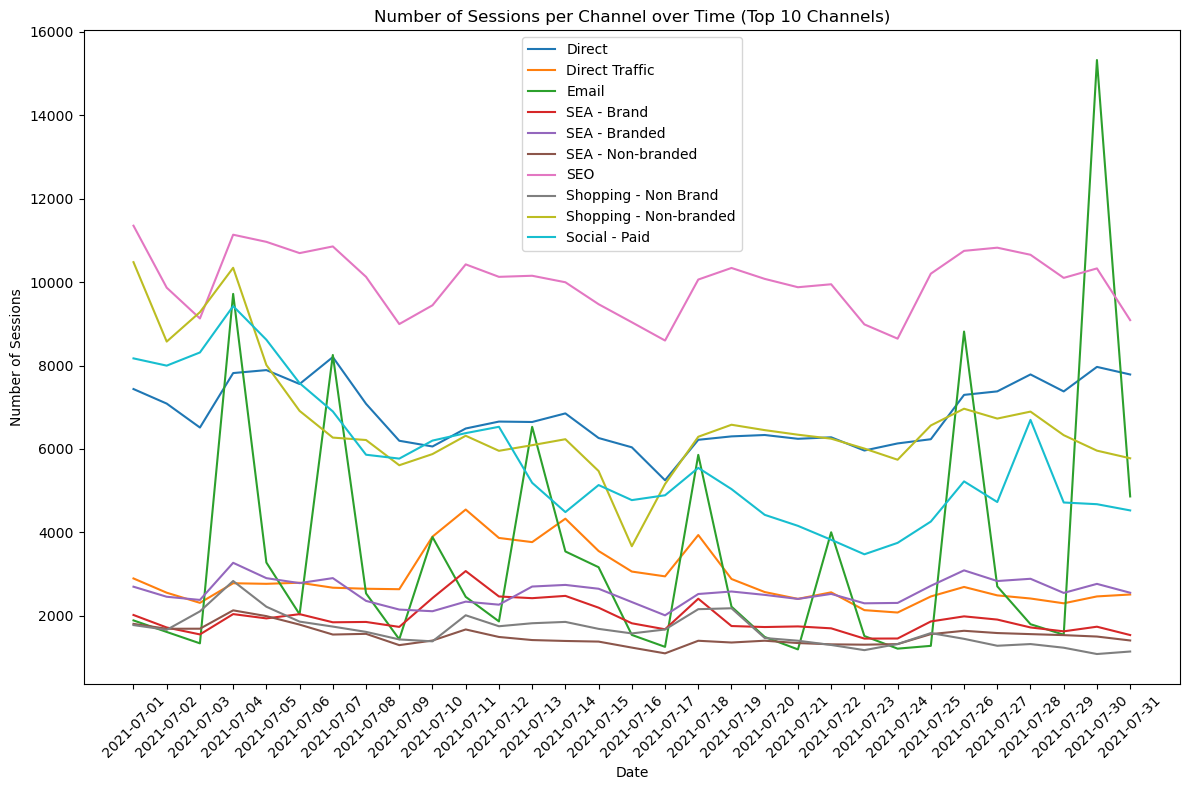

In [295]:

# Visualize the sessions over time for top 10 channels
plt.figure(figsize=(12, 8))
for channel, data in top_10_data.groupby('channel_name'):
    plt.plot(data['event_date'], data['session_count'], label=channel)

plt.title('Number of Sessions per Channel over Time (Top 10 Channels)')
plt.xlabel('Date')
plt.ylabel('Number of Sessions')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Bonus Question 2

#### Any other issues?


Possible Issue 1 : In conversions_df table, the min revenue of some conversions are 0.0. This should not be possible.

In [299]:
print(f"The min revenue is {conversions_df['revenue'].min()}")
print(f"The max revenue is {conversions_df['revenue'].max()}")
print(f"Number of conversions which show revenue as 0.0 are {len(conversions_df[conversions_df['revenue']==0.0])}")
conversions_df[conversions_df['revenue']==0.0].head(3)

The min revenue is 0.0
The max revenue is 1839.2
Number of conversions which show revenue as 0.0 are 197


,conv_id,user_id,conv_date,market,revenue
7,conv_id_11478,user_id_758246,2021-07-15,DE,0.0
10,conv_id_87,user_id_376090,2021-07-15,FR,0.0
151,conv_id_15098,user_id_47785,2021-07-15,NL,0.0


This looks like a data quality issue. But there can be other reasons for this such as:
1. A user used a 100% discount code while purchasing the item.
2. Problem while performing the purchase, may be the conversion was recorded but due to issue with payment the revenue was not processed.

Possible Issue 2 : Some conversions in conversions_df table are not present in attribution_conversion_ids table. This is not ideal.

In [300]:
# Get unique conv ids from conversions and attribution customer journey
conversion_ids = set(conversions_df['conv_id'])
attribution_conversion_ids = set(attribution_customer_journey_df['conv_id'])

# Find conv_ids in conversions that are not in attribution_customer_journey
missing_conv_ids = conversion_ids - attribution_conversion_ids

# Check if there are any missing
if missing_conv_ids:
    print(f"Number of Conversions without corresponding sessions in attribution_customer_journey are {len(missing_conv_ids)}")
else:
    print("All conversions have corresponding sessions in attribution_customer_journey.")

Number of Conversions without corresponding sessions in attribution_customer_journey are 10076


This discrepancy can indicate potential data quality issue. This could be a result of data incompleteness or issues with data being recorded. Ideally, conversions in conversions table should be present in attribution customer journey table as well.